<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
print(data.index.is_monotonic)
data.head()

True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим на пропуски

In [5]:
data.isna().sum()

num_orders    0
dtype: int64

## Анализ

Ресемплируем по 1 часу исходя из условия задачи

In [6]:
data = data.resample('1H').sum()

Проверим на стационарность 

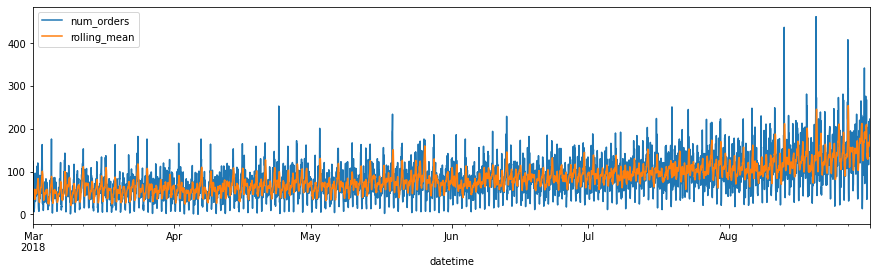

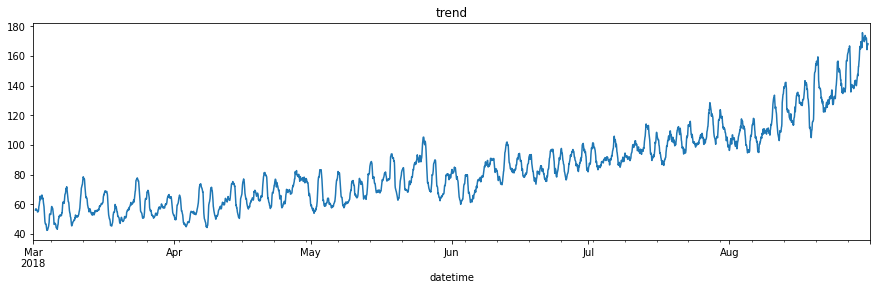

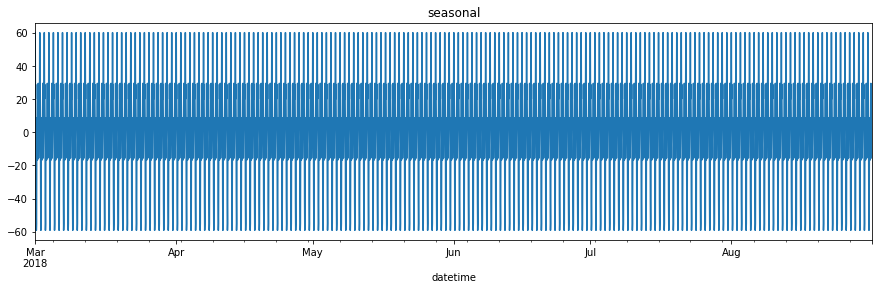

(422184.0, 422928.0)

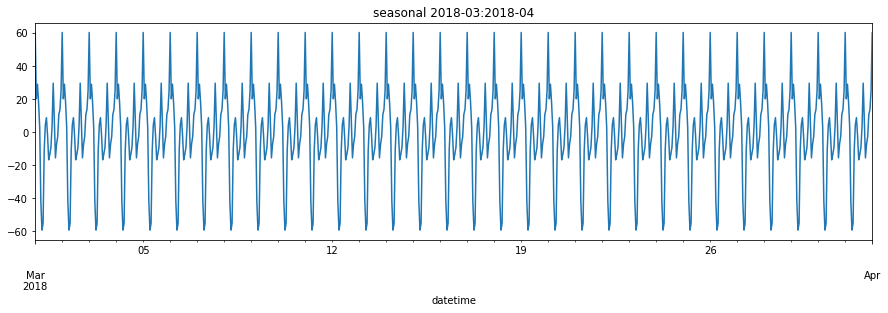

In [7]:
data['rolling_mean'] = data.rolling(7).mean()
data.plot(figsize = (15,4))
plt.show()

decomposed = seasonal_decompose(data['num_orders'])

decomposed.trend.plot(figsize = (15,4))
plt.title('trend')
plt.show()

decomposed.seasonal.plot(figsize = (15,4))
plt.title('seasonal')
plt.show()

decomposed.seasonal.plot(figsize = (15,4))
plt.title('seasonal 2018-03:2018-04')
plt.xlim('2018-03','2018-04')





Времянной ряд не стационарен, тренд постепенно ростёт , наблюдается суточная сезонность. 

## Обучение

Сделаем функцию, добавляющую дни месяца и дни недели так как по ним может быть цикличность, так же добавим отстающие значения и скользящее среднее

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Функция для подсчета RMSE

In [10]:
def rmse(target,predict):
    return np.sqrt(mean_squared_error(target,predict))


Разделим данные на признаки и цели а также выделим среди них тренировочную и тестовую выдборки.

In [11]:
make_features(data, 24, 60)

data = data.dropna()

features = data.drop('num_orders', axis=1)
target = data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

Добавим датафрейм results в котором будут содержаться результаты

In [12]:
results = pd.DataFrame(columns=['model','parametrs','rmse'])

Обучем модель LinearRegression

In [13]:
"""
model = LinearRegression()
model.fit(features_train,target_train)
predictions = model.predict(features_train)
results = results.append({'model': model,
                          'parametrs': '',
                          'rmse': rmse(target_train, predictions)},ignore_index=True)"""

"\nmodel = LinearRegression()\nmodel.fit(features_train,target_train)\npredictions = model.predict(features_train)\nresults = results.append({'model': model,\n                          'parametrs': '',\n                          'rmse': rmse(target_train, predictions)},ignore_index=True)"

Функцуя для вычесления лучшего результата по HalvingGridSearchCV, возвращает results с лучшими парамтрами.

In [14]:
score = make_scorer(rmse, greater_is_better=False)
     
def trainer (model_train, parameters):
    
    tscv = TimeSeriesSplit(n_splits=5)
    model = HalvingGridSearchCV(model_train, parameters, cv=tscv, scoring=score, n_jobs=-1)
    results = pd.DataFrame(columns=['model','parametrs','rmse'])
    
    model.fit(features_train,target_train)

    results = results.append({'model': model_train,
                              'parametrs': model.best_params_,
                              'rmse': -model.best_score_}, ignore_index=True)

    return results

LinearRegression

In [15]:
parametrs = {}
model = LinearRegression()
results = results.append(trainer(model,parametrs),  ignore_index=True)

DecisionTreeRegressor

In [16]:
parametrs = {'max_depth': range(2, 12, 2),'random_state': [12345]}
model = DecisionTreeRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

RandomForestRegressor

In [17]:
parametrs = {'n_estimators':[100,150,200],'max_depth': range(2, 5),'random_state': [12345]}
model = RandomForestRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

LGBMRegressor

In [18]:
parametrs = {'n_estimators':[100,150,200],'max_depth': [2,4,8],'learning_rate': [1, 2],'random_state': [12345]}
model = LGBMRegressor()
results = results.append(trainer(model,parametrs),  ignore_index=True)

In [19]:
results

,model,parametrs,rmse
0,LinearRegression(),{},27.243203
1,DecisionTreeRegressor(),"{'max_depth': 4, 'random_state': 12345}",30.500916
2,RandomForestRegressor(),"{'max_depth': 4, 'n_estimators': 200, 'random_...",28.027225
3,LGBMRegressor(),"{'learning_rate': 1, 'max_depth': 2, 'n_estima...",28.624146


Выделим лучший результат.

In [20]:
pd.options.display.max_colwidth = 90
results[results['rmse'].min() == results['rmse']]

,model,parametrs,rmse
0,LinearRegression(),{},27.243203


## Тестирование

Тестируем лучшую модель. 

In [21]:
model = LinearRegression()
model.fit(features_train, target_train)

predictions = model.predict(features_test)

print('RMSE', rmse(target_test, predictions))

RMSE 45.24583692779998
